In [1]:
from testproblems import generate_random_prob, random_problem_with_artifacts

In [2]:
from datastructures.operators import eqv_to_edges_tree, reformulate, invert_edges
from datastructures.graphutils import (default_tree, flat_graph_formulation, Node, COMP, VAR, sources, 
                                       draw_graph_graphical_props, copy_dicts)
from datastructures.rendering import render_incidence
import networkx as nx
from datastructures.tearing import min_max_scc2, min_arc_set_assign, min_arc_set, feedbacks

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Exploration

In [6]:
m = 10
n = 13
#seed 229 does not behave correctly
# (4,5,249,1.) is an interesting case
def func1(seed=229):
    sparsity = 3.#1.
    kwargs = random_problem_with_artifacts(m,n,seed,sparsity, independent_of_n=True)
    eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])
    print(np.mean([len(val) for val in eq_incidence.values()]))
    edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
    edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
    formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
    render_incidence(*formulation_scc, figsize=((4,4)), patchwidth=3);
    xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
    outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
    edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 
    formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
    render_incidence(*formulation_minassign, figsize=((4,4)));
    xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
    outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
    formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
    render_incidence(*formulation_minscc, figsize=((4,4)));
interact(func1, seed=(200,300)); # 20 looks good

interactive(children=(IntSlider(value=229, description='seed', max=300, min=200), Output()), _dom_classes=('wi…

In [7]:
# For presentation slides, (m,n,seed) = (4,5,221,1.0)
m = 4#37,4
n = 5#45,5
seed = 220#221#269#257#23
runs = (
    (0.5, 'sparsity_half.png'),
    (1., 'sparsity_one.png'),
    (1.5, 'sparsity_one_and_half.png')
)
sparsity, figname = 1., ''
m,n,seed,sparsity = (4,5,221,1.0)
#m,n,seed,sparsity = 20,24,8,1.5
m,n,seed,sparsity = 10,12,243,4.  #226
m,n,seed,sparsity = 10,13,230,3.  #226

In [8]:
kwargs = random_problem_with_artifacts(m,n,seed,sparsity, independent_of_n=True)

In [9]:
eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])

In [10]:
np.mean([len(val) for val in eq_incidence.values()])

3.1

In [27]:
vizargs_latex_largematrix = {'figsize':(4,4), 'rotation':60, 'hideticks':True, 'save':False, 'fontsize':22, 'patchwidth':4}
vizargs_latex_largematrix_save = vizargs_latex_largematrix | {'save':True}
saveext_defense = 'defense'
saveext_dissertation_final = 'dissertation_final'

In [28]:
vizargs = vizargs_latex_largematrix_save
saveext = 'jobtalk'
savename = lambda x: x+'_'+saveext+'.png'

## Undirected formulation

In [29]:
#outset[3]=7

In [30]:
edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
tree_undir[2].update({val:1 for val in outset_adj.values()})

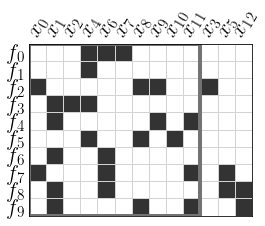

In [31]:
render_incidence(edges_undir, tree_undir, **vizargs);

In [32]:
# from scipy.sparse import csc_matrix
# from scipy.sparse.linalg import splu
# from datastructures.rendering import generate_incidence_matrix, plot_incidence_matrix
# from scipy.sparse.csgraph import reverse_cuthill_mckee

In [33]:
#A = generate_incidence_matrix(edges_dir[0], edges_dir[1], list(eqnidxs), [elt-m for elt in varidxs], diagonalgray=False)

In [34]:
# Asq = csc_matrix(A[:,list(outset_adj.values())], dtype=float)
# p = reverse_cuthill_mckee(Asq)

In [35]:
# Acm = (Asq.toarray()[p,:])[:,p]

In [36]:
# column_labels = ['$x_{}$'.format(var) for var in p]
# row_labels = ['$f_{}$'.format(fx) for fx in p]
# plot_incidence_matrix(Acm, column_labels, row_labels, **kwargs);

In [37]:
# column_labels = ['$x_{}$'.format(var) for var in range(10)]
# row_labels = ['$f_{}$'.format(fx) for fx in range(10)]
# plot_incidence_matrix(Asq.toarray(), column_labels, row_labels, **kwargs);

## Directed formulation
Baseline formulation

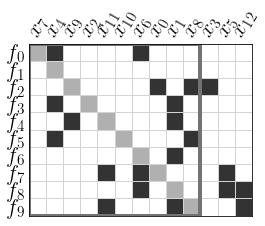

In [38]:
render_incidence(edges_dir, tree_dir, figname=savename("initial_directed_rho_5"), **vizargs);

### Reformulated based on feedback

In [39]:
D = flat_graph_formulation(*edges_dir)
fvars, fcomps = feedbacks(D, [Node(idx,COMP) for idx in eqnidxs])
outset_f = {comp:var for comp,var in outset.items() if Node(comp,COMP) not in fcomps}
edges_fb,tree_fb,_ = eqv_to_edges_tree(eq_incidence, outset_f, n_eqs=m)
tree_fb[2].update({v.name: 1 for v in sorted(fvars, key=lambda x: x.name)})

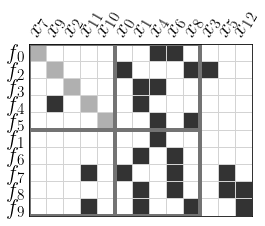

In [41]:
render_incidence(edges_fb, tree_fb, figname=savename("reformulated_feedback"), **vizargs);

## Condensation

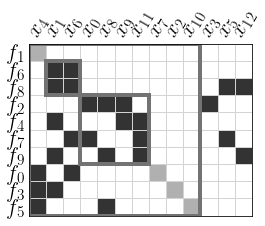

In [42]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
render_incidence(*formulation_scc, figname=savename("condensation"), **vizargs);

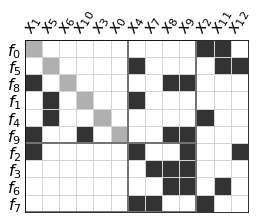

In [25]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc, figsize=((4,4)), rotation=60, hideticks=True,);

## DM fine

In [215]:
#draw_graph_graphical_props(G, prog='neato', figsize=(11,4))

In [55]:
Ein_no_source = {comp:tuple(var for var in allvars if var in outset.values()) for comp,allvars in eq_incidence.items()}
G = flat_graph_formulation(Ein_no_source,{},{},{VAR: 'x_{{{}}}', COMP: 'f_{{{}}}'})
matching = nx.bipartite.maximum_matching(G)
m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
edges_dir_m,tree_dir_m,_ = eqv_to_edges_tree(eq_incidence, m_out, n_eqs=m)

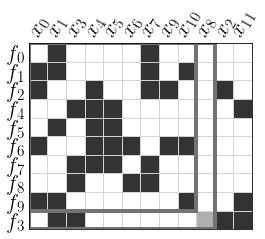

In [56]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1)
render_incidence(*formulation_scc_m, **vizargs);

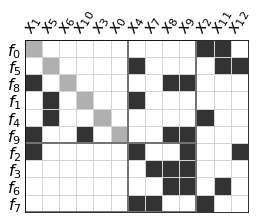

In [39]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc_m, figsize=((4,4)), hideticks=True);

## MFA

In [27]:
cycles, elimset, model = min_arc_set(edges_varonleft, outset, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [28]:
elimset, {outset_adj[elt] for elt in elimset}

({2, 5, 9}, {0, 4, 5})

In [29]:
outset_mfa = {key:val for key,val in outset_adj.items() if key not in elimset}

#### Note: There is no IDF/MDF

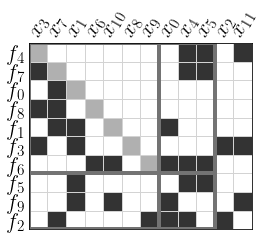

In [47]:
formulation_mfa = reformulate(edges_dir, tree_dir, outset_adj, outset_mfa, root_solver_name=1, solveforvars=2)
render_incidence(*formulation_mfa, figname=savename("fac_opt"), **vizargs);

## Tearing

In [43]:
fixed_inputs = set(varidxs)-set(outset.values())

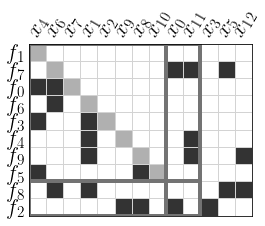

In [44]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_tear = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_tear = reformulate(edges_dir, tree_dir, outset_adj, outset_tear, 
                               not_outputs={elt-m for elt in fixed_inputs},
                               root_solver_name=1)
render_incidence(*formulation_tear, figname=savename("tear_opt"), **vizargs);

## Tearing with input

In [45]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)

In [46]:
edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 

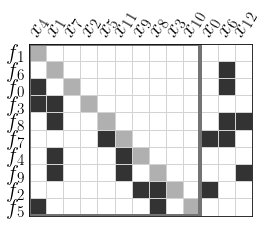

In [47]:
formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
render_incidence(*formulation_minassign, figname=savename("assign_opt"), **vizargs);

## Min scc

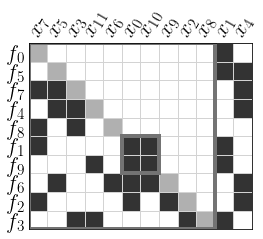

In [53]:
xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
render_incidence(*formulation_minscc, figname=savename("scc_opt"), **vizargs);